# Using the hyper parameters, compare methods on testing set

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")
os.getcwd()

'/Users/nathansimonis/Desktop/FinanicalBigData-EPFL-main/code'

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pyarrow.feather as feather
import networkx as nx

from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from utils.cv import PurgedGroupTimeSeriesSplit, generate_all_combinations
from lightgbm import LGBMClassifier
from matplotlib.colors import ListedColormap

from utils.metrics import utility_score

from utils.data_preparation import (
    preprocess,
    impute,
    scfm,
    cwfs
)

from utils.clustering import (
    clean_matrix_,
    runN_Louvain
)

from utils.plots import (
    plot_clusters,
    plot_merged_subclusters,
    plot_cluster_importance
)

import pickle
import gc

In [4]:
df = feather.read_feather("../data/raw/train.feather")
float64_cols = df.select_dtypes(include='float64').columns
mapper = {col_name: np.float32 for col_name in float64_cols}
df = df.astype(mapper, copy=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float32(135), int32(3)
memory usage: 1.2 GB


In [5]:
# Define label
df["action"] = np.where(df["resp"]*df["weight"]>0, 1, 0)
# Get feature names
features = df.columns[df.columns.str.contains("feature")]

# Split data
gap = 10
split = 400
train = df[df.date <= split]
test = df[df.date > split+gap]

In [6]:
param_selection = pickle.load(open("../data/clean/best_parameters_selection_wo_n_clusters.pickle", "rb"))
param_subscluster = pickle.load(open("../data/clean/best_parameters_subclusters.pickle", "rb"))

In [7]:
X_tr = train[features].copy()
y_tr = train["action"]

X_te = test[features].copy()
y_te = test["action"]

In [8]:
del test
gc.collect()

133

100%|██████████| 100/100 [00:28<00:00,  3.46it/s]


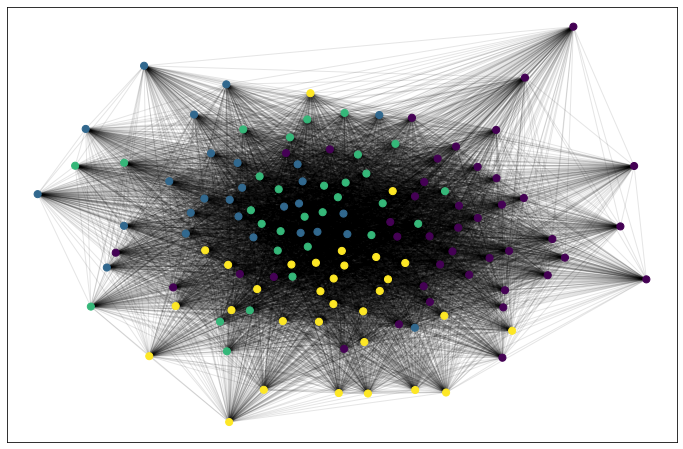

In [9]:
# Cluster features.


X_tr_mean, X_tr_std = X_tr.mean(), X_tr.std()

X_tr.fillna(X_tr_mean, inplace=True)
X_te.fillna(X_tr_mean, inplace=True)

# Clustering step.
## Compute and clean correlation matrix.
### Normalize before computing corr matrix

X_tr_norm = (X_tr - X_tr_mean) / X_tr_std
X_te_norm = (X_te - X_tr_mean) / X_tr_std

#C_tr = np.corrcoef(X_tr_norm, rowvar=False)  # Faster than pd.DataFrame.corr()
C_tr = pickle.load(open("../data/clean/C_tr.pickle", "rb"))
C_tr_clean = clean_matrix_(X_tr_norm)

## Compute clusters by running Louvain N times.
n_runs = 100
part_tr, G = runN_Louvain(C_tr_clean, N=n_runs, verbose=True, random_state=42)
part_tr["feature"] = ["feature_"+str(part_tr.index[i]) for i in range(len(part_tr))]

plot_clusters(part_tr, G, save=True)

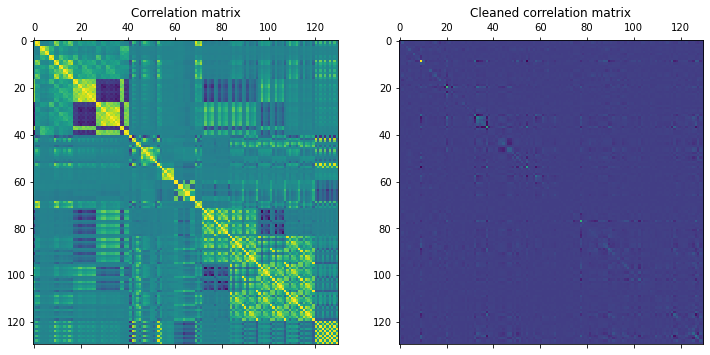

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,7))
ax1.matshow(C_tr)
ax1.set_title("Correlation matrix")
ax2.matshow(C_tr_clean)
ax2.set_title("Cleaned correlation matrix")
plt.savefig("../figures/correlation_matrices.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [11]:
# Run subclustering
X_tr_sc, X_te_sc = scfm(
    part_tr,
    X_tr_norm,
    X_te_norm,
    y_tr,
    agg=param_subscluster["agg"],
    verbose=True,
    seed=42
)

100%|██████████| 4/4 [00:17<00:00,  4.39s/it]


In [13]:
#lgbm_all = LGBMClassifier().fit(X_tr, y_tr)
lgbm_all = pickle.load(open("../data/clean/lgbm_all.pickle", "rb"))

In [15]:
#lgbm_subcluster = LGBMClassifier().fit(X_tr_sc, y_tr)
lgbm_subcluster = pickle.load(open("../data/clean/lgbm_subcluster.pcikle", "rb"))

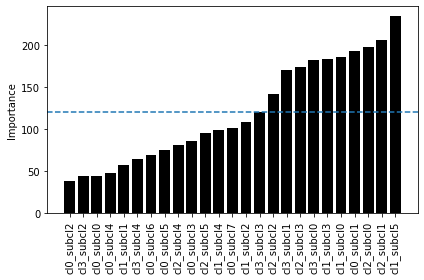

In [16]:
# Plot importances of the subcluster method.
imp_sc = lgbm_subcluster.feature_importances_
plot_merged_subclusters(imp_sc, X_tr_sc.columns, save=True)

In [17]:
imp_tr = lgbm_all.feature_importances_
part_tr["importance"] = imp_tr

In [18]:
## CV for the clustered MDA
cv = PurgedGroupTimeSeriesSplit(
    n_splits = 5,
    max_train_group_size=189,
    max_test_group_size=63,
    group_gap=10
)

In [19]:
## Run cluster weighted feature selection
#sub_features, ns, mda_plot = cwfs(
#    K = param_selection["K"],
#    partitions = part_tr,
#    df = train,
#    X_tr = X_tr_norm,
#    y_tr = y_tr,
#    tr = list(train.index),
#    cv = cv,
#    plot_importance=True
#)

sub_features = pickle.load(open("../data/clean/sub_features.pickle", "rb"))
ns = pickle.load(open("../data/clean/ns.pickle", "rb"))
c_imp = pickle.load(open("../data/clean/c_imp.pickle", "rb"))

X_tr_sel = X_tr.loc[:, sub_features]
X_te_sel = X_te.loc[:, sub_features]

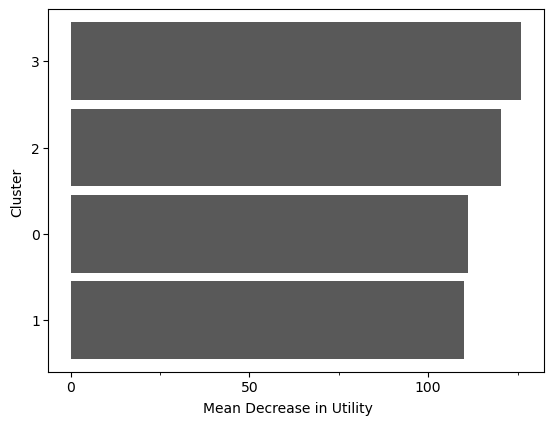

<ggplot: (8794506287641)>

In [20]:
plot_cluster_importance(c_imp, show=False)

In [23]:
part_tr[part_tr.feature.isin(sub_features)]

,cluster,feature,importance
0,0,feature_0,0
1,0,feature_1,143
2,0,feature_2,20
3,0,feature_3,35
4,0,feature_4,16
9,1,feature_9,60
11,1,feature_11,7
30,1,feature_30,33
32,1,feature_32,0
33,1,feature_33,4


In [24]:
#lgbm_selection = LGBMClassifier().fit(X_tr_sel, y_tr)
lgbm_selection = pickle.load(open("../data/clean/lgbm_selection.pickle", "rb"))

In [25]:
# Make predictions

pred_all = lgbm_all.predict(X_te)
pred_selection = lgbm_selection.predict(X_te_sel)
pred_subcluster = lgbm_subcluster.predict(X_te_sc)

In [26]:
# Evaluate

te = X_te.index

score_te_all = utility_score(
    date=df["date"].iloc[te].values,
    weight=df["weight"].iloc[te].values,
    resp=df["resp"].iloc[te].values,
    action=pred_all
)

score_te_sel = utility_score(
    date=df["date"].iloc[te].values,
    weight=df["weight"].iloc[te].values,
    resp=df["resp"].iloc[te].values,
    action=pred_selection
)


score_te_sc = utility_score(
    date=df["date"].iloc[te].values,
    weight=df["weight"].iloc[te].values,
    resp=df["resp"].iloc[te].values,
    action=pred_subcluster
)

scores_df = pd.Series({"All features":score_te_all,
                       "CWFS":score_te_sel,
                       "SCFM":score_te_sc
                      })

In [27]:
scores_df

All features    418.198695
CWFS            358.679853
SCFM            264.252547
dtype: float64

In [28]:
# scores_df.to_pickle("../data/clean/scores_df.df")

In [29]:
print(scores_df.round(4).to_latex())

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
All features &  418.1987 \\
CWFS         &  358.6799 \\
SCFM         &  264.2525 \\
\bottomrule
\end{tabular}

